# MLflow Experiment Tracking Lab

This notebook demonstrates MLflow experiment tracking with the California Housing dataset. We'll cover:

1. **Part 1**: MLflow Autologging
2. **Part 2**: Manual Tracking with `mlflow.start_run()`
3. **Part 3**: Model Loading
4. **Part 4**: Model Serving

## Dataset: California Housing

The California Housing dataset contains features about houses in California and predicts median house values (regression task).

**Features:**
- MedInc: Median income in block group
- HouseAge: Median house age in block group
- AveRooms: Average number of rooms per household
- AveBedrms: Average number of bedrooms per household
- Population: Block group population
- AveOccup: Average number of household members
- Latitude: Block group latitude
- Longitude: Block group longitude

**Target:** Median house value (in hundreds of thousands of dollars)


In [3]:
# Import necessary libraries
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"MLflow version: {mlflow.__version__}")


Libraries imported successfully!
MLflow version: 3.6.0


In [4]:
# Load and explore the dataset
data = fetch_california_housing()
X, y = data.data, data.target
feature_names = data.feature_names

# Create DataFrame for better visualization
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(f"Dataset shape: {X.shape}")
print(f"\nFeature names: {list(feature_names)}")
print(f"\nTarget statistics:")
print(df['target'].describe())

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")


Dataset shape: (20640, 8)

Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Target statistics:
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: target, dtype: float64

Training set size: 16512
Test set size: 4128
Number of features: 8


---

## Part 1: MLflow Autologging

MLflow autologging automatically tracks parameters, metrics, and models when using supported frameworks like scikit-learn. This makes it easy to track experiments without manual logging.

### Steps:
1. Enable MLflow autologging for scikit-learn
2. Create a named experiment
3. Train two different models (Random Forest and Gradient Boosting)
4. MLflow will automatically log parameters, metrics, and models


In [5]:
# Enable MLflow autologging for scikit-learn
mlflow.sklearn.autolog()

# Create a named experiment
experiment_name = "california_housing_autolog"
mlflow.set_experiment(experiment_name)

print(f"Autologging enabled for scikit-learn")
print(f"Experiment: {experiment_name}")


2025/11/17 19:22:10 INFO mlflow.tracking.fluent: Experiment with name 'california_housing_autolog' does not exist. Creating a new experiment.


Autologging enabled for scikit-learn
Experiment: california_housing_autolog


In [6]:
# Train Random Forest Regressor (Model 1)
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

# MLflow will automatically log this training run
rf_model.fit(X_train, y_train)

# Evaluate
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)

rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train_pred))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_pred))
rf_test_r2 = r2_score(y_test, rf_test_pred)

print(f"\nRandom Forest Results:")
print(f"  Train RMSE: {rf_train_rmse:.4f}")
print(f"  Test RMSE: {rf_test_rmse:.4f}")
print(f"  Test R²: {rf_test_r2:.4f}")


2025/11/17 19:22:20 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '09c736a209684465afa018f003bec254', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Training Random Forest Regressor...

Random Forest Results:
  Train RMSE: 0.4181
  Test RMSE: 0.5445
  Test R²: 0.7737


In [7]:
# Train Gradient Boosting Regressor (Model 2)
print("Training Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# MLflow will automatically log this training run
gb_model.fit(X_train, y_train)

# Evaluate
gb_train_pred = gb_model.predict(X_train)
gb_test_pred = gb_model.predict(X_test)

gb_train_rmse = np.sqrt(mean_squared_error(y_train, gb_train_pred))
gb_test_rmse = np.sqrt(mean_squared_error(y_test, gb_test_pred))
gb_test_r2 = r2_score(y_test, gb_test_pred)

print(f"\nGradient Boosting Results:")
print(f"  Train RMSE: {gb_train_rmse:.4f}")
print(f"  Test RMSE: {gb_test_rmse:.4f}")
print(f"  Test R²: {gb_test_r2:.4f}")


2025/11/17 19:22:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd5cc8562a1ac4404b27b8e501d081969', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Training Gradient Boosting Regressor...

Gradient Boosting Results:
  Train RMSE: 0.4177
  Test RMSE: 0.4977
  Test R²: 0.8110


**View results in MLflow UI:**
```bash
mlflow ui
```

Open http://localhost:5000 in your browser to see the auto-logged experiments. You should see:
- Automatically logged hyperparameters (n_estimators, max_depth, etc.)
- Automatically logged metrics (training and validation scores)
- Automatically saved models
- Model signatures inferred from data

---

## Part 2: Manual Tracking with `mlflow.start_run()`

Manual tracking gives you full control over what gets logged. We'll use `mlflow.start_run()` to manually log parameters, metrics, and models.

### Variations implemented:
- **Additional Metrics**: Log custom metrics (MAPE - Mean Absolute Percentage Error)
- **Tags and Notes**: Use `mlflow.set_tags()` to categorize runs
- **Artifact Logging**: Log visualization (feature importance plot)


In [8]:
# Disable autologging for manual control
mlflow.sklearn.autolog(disable=True)

# Create a new experiment for manual tracking
experiment_name = "california_housing_manual"
mlflow.set_experiment(experiment_name)

print(f"Manual tracking enabled")
print(f"Experiment: {experiment_name}")


2025/11/17 19:22:46 INFO mlflow.tracking.fluent: Experiment with name 'california_housing_manual' does not exist. Creating a new experiment.


Manual tracking enabled
Experiment: california_housing_manual


In [9]:
# Manual tracking with Random Forest
with mlflow.start_run(run_name="RandomForest_Manual_Baseline") as run:
    # Set tags to categorize the run
    mlflow.set_tags({
        "model_type": "RandomForest",
        "version": "baseline",
        "dataset": "california_housing",
        "purpose": "manual_tracking_demo"
    })
    
    # Manually log hyperparameters (at least 3)
    params = {
        "n_estimators": 100,
        "max_depth": 10,
        "min_samples_split": 5,
        "random_state": 42
    }
    mlflow.log_params(params)
    
    # Train model
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Manually log metrics (at least 3)
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("test_r2", test_r2)
    
    # Log custom metrics (Mean Absolute Percentage Error)
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    mlflow.log_metric("train_mape", train_mape)
    mlflow.log_metric("test_mape", test_mape)
    
    # Log model with signature inference
    mlflow.sklearn.log_model(
        model,
        "model",
        signature=mlflow.models.infer_signature(X_test[:5], y_test_pred[:5])
    )
    
    # Create and log feature importance plot (artifact logging)
    plt.figure(figsize=(10, 6))
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.title("Feature Importances - Random Forest")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.ylabel("Importance")
    plt.tight_layout()
    
    # Log the plot as an artifact
    mlflow.log_figure(plt.gcf(), "feature_importance.png")
    plt.close()
    
    # Store run ID for later use
    rf_manual_run_id = run.info.run_id
    
    print(f"\nManual Tracking - Random Forest Results:")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE: {test_mae:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test MAPE: {test_mape:.2f}%")
    print(f"\n  Run ID: {rf_manual_run_id}")


2025/11/17 19:22:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Manual Tracking - Random Forest Results:
  Test RMSE: 0.5445
  Test MAE: 0.3666
  Test R²: 0.7737
  Test MAPE: 21.59%

  Run ID: a140370fc6c64421b0509cbe0477d668


In [10]:
# Manual tracking with Gradient Boosting - Improved version
with mlflow.start_run(run_name="GradientBoosting_Manual_Improved") as run:
    # Set tags with different version
    mlflow.set_tags({
        "model_type": "GradientBoosting",
        "version": "improved",
        "dataset": "california_housing",
        "purpose": "manual_tracking_demo"
    })
    
    # Manually log hyperparameters
    params = {
        "n_estimators": 150,
        "max_depth": 6,
        "learning_rate": 0.05,
        "random_state": 42
    }
    mlflow.log_params(params)
    
    # Train model
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Manually log metrics
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("train_r2", train_r2)
    mlflow.log_metric("test_r2", test_r2)
    
    # Log custom metrics
    train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
    mlflow.log_metric("train_mape", train_mape)
    mlflow.log_metric("test_mape", test_mape)
    
    # Log model with signature
    mlflow.sklearn.log_model(
        model,
        "model",
        signature=mlflow.models.infer_signature(X_test[:5], y_test_pred[:5])
    )
    
    # Create and log feature importance plot
    plt.figure(figsize=(10, 6))
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.title("Feature Importances - Gradient Boosting")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.ylabel("Importance")
    plt.tight_layout()
    
    mlflow.log_figure(plt.gcf(), "feature_importance.png")
    plt.close()
    
    # Store run ID
    gb_manual_run_id = run.info.run_id
    
    print(f"\nManual Tracking - Gradient Boosting Results:")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test MAE: {test_mae:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Test MAPE: {test_mape:.2f}%")
    print(f"\n  Run ID: {gb_manual_run_id}")


2025/11/17 19:23:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Manual Tracking - Gradient Boosting Results:
  Test RMSE: 0.4861
  Test MAE: 0.3238
  Test R²: 0.8197
  Test MAPE: 18.91%

  Run ID: 5745bf67b3ad4bdc95da50881fb77368


In [11]:
# Load the model using the run ID from manual tracking
# Replace with your actual run ID if needed
model_uri = f"runs:/{gb_manual_run_id}/model"

print(f"Loading model from: {model_uri}")

# Load the model
loaded_model = mlflow.sklearn.load_model(model_uri)

print(f"Model loaded successfully!")
print(f"Model type: {type(loaded_model)}")


Loading model from: runs:/5745bf67b3ad4bdc95da50881fb77368/model
Model loaded successfully!
Model type: <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>


In [12]:
# Make predictions on test data with the loaded model
test_predictions = loaded_model.predict(X_test)

print(f"Number of test samples: {len(X_test)}")
print(f"Number of predictions: {len(test_predictions)}")
print(f"\nFirst 10 predictions:")
print("-" * 60)
print(f"{'Index':<8} {'Predicted':<15} {'Actual':<15} {'Error':<15}")
print("-" * 60)

for i in range(10):
    error = abs(test_predictions[i] - y_test[i])
    print(f"{i:<8} {test_predictions[i]:<15.4f} {y_test[i]:<15.4f} {error:<15.4f}")

# Calculate metrics to verify model works correctly
loaded_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
loaded_mae = mean_absolute_error(y_test, test_predictions)
loaded_r2 = r2_score(y_test, test_predictions)

print("\n" + "-" * 60)
print(f"Loaded Model Performance:")
print(f"  RMSE: {loaded_rmse:.4f}")
print(f"  MAE: {loaded_mae:.4f}")
print(f"  R²: {loaded_r2:.4f}")
print("-" * 60)


Number of test samples: 4128
Number of predictions: 4128

First 10 predictions:
------------------------------------------------------------
Index    Predicted       Actual          Error          
------------------------------------------------------------
0        0.5427          0.4770          0.0657         
1        0.9786          0.4580          0.5206         
2        4.8941          5.0000          0.1059         
3        2.4977          2.1860          0.3117         
4        2.2423          2.7800          0.5377         
5        1.7613          1.5870          0.1743         
6        2.3095          1.9820          0.3275         
7        1.6116          1.5750          0.0366         
8        2.7454          3.4000          0.6546         
9        4.7112          4.4660          0.2452         

------------------------------------------------------------
Loaded Model Performance:
  RMSE: 0.4861
  MAE: 0.3238
  R²: 0.8197
-----------------------------------------

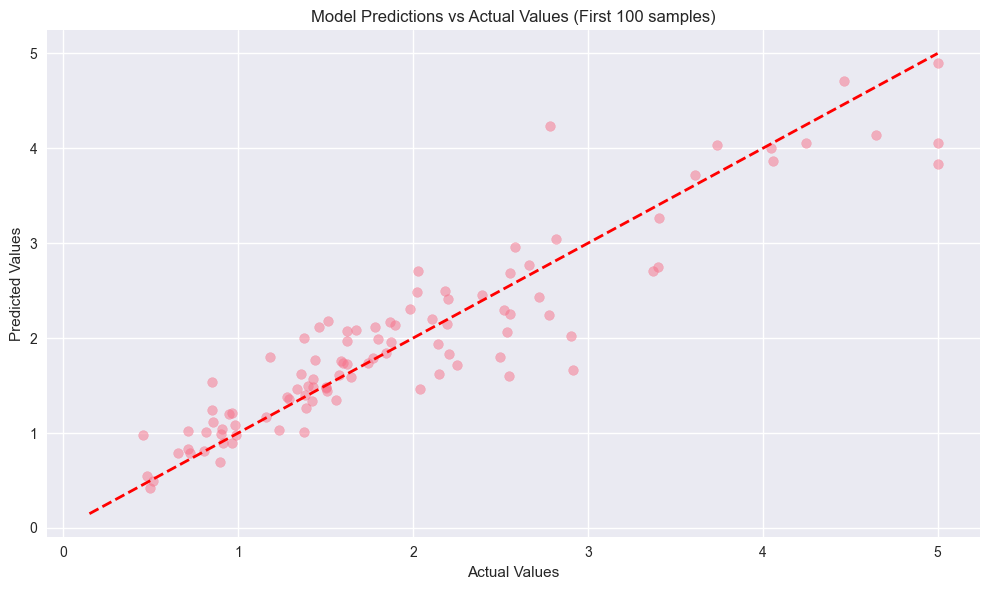

In [13]:
# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:100], test_predictions[:100], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs Actual Values (First 100 samples)')
plt.tight_layout()
plt.show()


---

## Part 4: Model Serving

MLflow can serve models as REST APIs. This allows you to make predictions via HTTP requests.

### Steps:
1. Serve the model using `mlflow models serve` on port 5001
2. Make predictions via HTTP POST requests
3. Test with batch predictions

**Note:** Model serving must be done from the terminal. Use the command below:

```bash
mlflow models serve -m runs:/<RUN_ID>/model -p 5001 --no-conda
```

For example, using the run ID from Part 3:
```bash
mlflow models serve -m runs:/{gb_manual_run_id}/model -p 5001 --no-conda
```

After starting the server, run the `predict_api.py` script or use the code below to test it.


In [14]:
import requests
import json

# Server URL
SERVER_URL = "http://localhost:5001/invocations"

# Test with single prediction
print("="*60)
print("TEST 1: Single Sample Prediction")
print("="*60)

single_sample = X_test[0:1].tolist()
payload = {
    "dataframe_split": {
        "data": single_sample
    }
}

try:
    response = requests.post(
        SERVER_URL,
        json=payload,
        headers={"Content-Type": "application/json"},
        timeout=10
    )
    response.raise_for_status()
    
    predictions = response.json()
    print(f"Input shape: (1, {X_test.shape[1]})")
    print(f"Response status: {response.status_code}")
    print(f"Prediction: {predictions}")
    print(f"Actual value: {y_test[0]:.4f}")
    
except requests.exceptions.ConnectionError:
    print("ERROR: Could not connect to MLflow model server.")
    print("Please start the server using:")
    print(f"  mlflow models serve -m runs:/{gb_manual_run_id}/model -p 5001 --no-conda")
except Exception as e:
    print(f"Error: {e}")


TEST 1: Single Sample Prediction
ERROR: Could not connect to MLflow model server.
Please start the server using:
  mlflow models serve -m runs:/5745bf67b3ad4bdc95da50881fb77368/model -p 5001 --no-conda


In [15]:
# Test with batch predictions (multiple samples)
print("\n" + "="*60)
print("TEST 2: Batch Predictions (10 samples)")
print("="*60)

batch_samples = X_test[:10].tolist()
batch_actual = y_test[:10]

payload = {
    "dataframe_split": {
        "data": batch_samples
    }
}

try:
    response = requests.post(
        SERVER_URL,
        json=payload,
        headers={"Content-Type": "application/json"},
        timeout=10
    )
    response.raise_for_status()
    
    predictions = response.json()
    
    # Handle different response formats
    if isinstance(predictions, list):
        batch_predictions = predictions if isinstance(predictions[0], (int, float)) else [p[0] for p in predictions]
    else:
        batch_predictions = predictions
    
    print(f"Input shape: (10, {X_test.shape[1]})")
    print(f"Response status: {response.status_code}")
    print(f"\n{'Index':<8} {'Predicted':<15} {'Actual':<15} {'Error':<15}")
    print("-" * 60)
    
    for i in range(len(batch_predictions)):
        error = abs(batch_predictions[i] - batch_actual[i])
        print(f"{i:<8} {batch_predictions[i]:<15.4f} {batch_actual[i]:<15.4f} {error:<15.4f}")
    
    # Calculate batch statistics
    batch_mae = np.mean(np.abs(np.array(batch_predictions) - batch_actual))
    batch_rmse = np.sqrt(np.mean((np.array(batch_predictions) - batch_actual) ** 2))
    
    print("\n" + "-" * 60)
    print(f"Batch Statistics:")
    print(f"  Mean Absolute Error: {batch_mae:.4f}")
    print(f"  Root Mean Squared Error: {batch_rmse:.4f}")
    print("-" * 60)
    
except requests.exceptions.ConnectionError:
    print("ERROR: Could not connect to MLflow model server.")
    print("Please start the server using:")
    print(f"  mlflow models serve -m runs:/{gb_manual_run_id}/model -p 5001 --no-conda")
except Exception as e:
    print(f"Error: {e}")



TEST 2: Batch Predictions (10 samples)
ERROR: Could not connect to MLflow model server.
Please start the server using:
  mlflow models serve -m runs:/5745bf67b3ad4bdc95da50881fb77368/model -p 5001 --no-conda


---

## Summary

This lab demonstrated:

1. **MLflow Autologging**: Automatically tracked scikit-learn models with minimal code
2. **Manual Tracking**: Full control over parameters, metrics, and artifacts using `mlflow.start_run()`
3. **Model Loading**: Retrieved saved models by run ID and made predictions
4. **Model Serving**: Served models as REST APIs for production use

### Variations Implemented:
- **Additional Metrics**: Custom MAPE (Mean Absolute Percentage Error) metric
- **Tags and Notes**: Used tags to categorize runs (baseline, improved, etc.)
- **Artifact Logging**: Logged feature importance plots as artifacts
- **Multiple Runs Comparison**: Compared different models and hyperparameters

### Next Steps:
- View all experiments in MLflow UI: `mlflow ui`
- Compare runs side-by-side
- Register best model for production: `mlflow.register_model()`
- Use model serving for real-time predictions
